Load Libraries

In [13]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

#!pip install dython

from dython.nominal import associations
import seaborn as sns

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

#!pip install kneed #Correct the typo in pip install command
from kneed import KneeLocator #Import KneeLocator class

from sklearn.model_selection import train_test_split

import statsmodels.api as sm

Load Data

In [14]:
file_id = '1U2UaHWRSkUXfJBn4kBHPYttd3dvw_CZF'
url = f'https://drive.google.com/uc?id={file_id}'
Nba_data = pd.read_csv(url, encoding='utf-8')

# dep_var = 'distance' --> .678
# dep_var = 'turnovers' #--> .788
#dep_var = 'assists' #--> .0.597
dep_var = 'turnovers' #--> .788
Nba_data = Nba_data[Nba_data['season'].str[:4].astype(int) > 2012]

# testing
# Nba_data = Nba_data.loc[(Nba_data['distance'] != 0) & (Nba_data['touches'] != 0)]

Checking Data

In [15]:
Nba_data.head()

,game_id,season,team_id,team_name,tri_code,team_slug,minutes,field_goals_made,field_goals_attempted,field_goals_percentage,...,uncontested_field_goals_percentage,field_goal_percentage,defended_at_rim_field_goals_made,defended_at_rim_field_goals_attempted,defended_at_rim_field_goal_percentage,opponent_points,is_home_team,won_game,is_playoff_game,is_regular_game
12495,41300405,2013-14,1610612759,Spurs,SAS,spurs,240:00,37.0,78.0,0.474,...,0.475,0.474,15.0,24.0,0.625,87.0,1,1,1,0
12496,41300404,2013-14,1610612748,Heat,MIA,heat,240:00,32.0,71.0,0.451,...,0.439,0.451,16.0,19.0,0.842,107.0,1,0,1,0
12497,41300403,2013-14,1610612748,Heat,MIA,heat,240:00,32.0,62.0,0.516,...,0.516,0.516,14.0,20.0,0.700,111.0,1,0,1,0
12498,41300402,2013-14,1610612759,Spurs,SAS,spurs,240:00,36.0,82.0,0.439,...,0.452,0.439,17.0,24.0,0.708,98.0,1,0,1,0
12499,41300401,2013-14,1610612759,Spurs,SAS,spurs,240:00,40.0,68.0,0.588,...,0.472,0.588,12.0,21.0,0.571,95.0,1,1,1,0


Shake's edit:
Filter out data from before 2013 season

In [16]:
# Nba_data = Nba_data[Nba_data['season'].str[:4].astype(int) > 2012]

# # testing
# Nba_data = Nba_data.loc[(Nba_data['distance'] != 0) & (Nba_data['touches'] != 0)]

Drop Unnecessary columns (run code, then comment when encounter an eror)

In [17]:
Nba_data = Nba_data[Nba_data['is_home_team'] == 1]
Nba_data = Nba_data.drop(columns=['game_id', 'team_id', 'season', 'is_playoff_game', 'is_regular_game'])

Check Data

In [18]:
Nba_data

,team_name,tri_code,team_slug,minutes,field_goals_made,field_goals_attempted,field_goals_percentage,three_pointers_made,three_pointers_attempted,three_pointers_percentage,...,uncontested_field_goals_made,uncontested_field_goals_attempted,uncontested_field_goals_percentage,field_goal_percentage,defended_at_rim_field_goals_made,defended_at_rim_field_goals_attempted,defended_at_rim_field_goal_percentage,opponent_points,is_home_team,won_game
12495,Spurs,SAS,spurs,240:00,37.0,78.0,0.474,12.0,26.0,0.462,...,19.0,40.0,0.475,0.474,15.0,24.0,0.625,87.0,1,1
12496,Heat,MIA,heat,240:00,32.0,71.0,0.451,9.0,22.0,0.409,...,18.0,41.0,0.439,0.451,16.0,19.0,0.842,107.0,1,0
12497,Heat,MIA,heat,240:00,32.0,62.0,0.516,10.0,21.0,0.476,...,16.0,31.0,0.516,0.516,14.0,20.0,0.700,111.0,1,0
12498,Spurs,SAS,spurs,240:00,36.0,82.0,0.439,12.0,26.0,0.462,...,19.0,42.0,0.452,0.439,17.0,24.0,0.708,98.0,1,0
12499,Spurs,SAS,spurs,240:00,40.0,68.0,0.588,13.0,25.0,0.520,...,17.0,36.0,0.472,0.588,12.0,21.0,0.571,95.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27652,Grizzlies,MEM,grizzlies,265:00,50.0,108.0,0.463,8.0,38.0,0.211,...,0.0,0.0,0.000,0.463,0.0,0.0,0.000,122.0,1,1
27653,Pistons,DET,pistons,265:00,47.0,95.0,0.495,11.0,35.0,0.314,...,0.0,0.0,0.000,0.495,0.0,0.0,0.000,130.0,1,0
27654,Mavericks,DAL,mavericks,240:00,35.0,94.0,0.372,14.0,46.0,0.304,...,0.0,0.0,0.000,0.372,0.0,0.0,0.000,104.0,1,0
27655,Warriors,GSW,warriors,207:10,37.0,79.0,0.468,15.0,42.0,0.357,...,0.0,0.0,0.000,0.469,0.0,0.0,0.000,89.0,1,1


Instead of points as the dependent variable. Lets try the field goal percentage column. Reason: Field goals count as all shots attempted.

Detecting missing values.
new_data is filtering the DataFrame Nba_data to remove rows where the points column has missing (NaN) values.

In [19]:
#Can drop because its a small percentage of data
def show_missing_vals(df:pd.DataFrame)->pd.DataFrame:
    return Nba_data.isna().sum().divide(len(Nba_data)).sort_values(ascending=False)

print(show_missing_vals(Nba_data))

#Cleaned data stored in a variable
cleaned_Nba_data = Nba_data.dropna()

cleaned_Nba_data.isna().sum().sum()

rebound_percentage            0.008376
defensive_rating              0.008376
offensive_rating              0.008376
estimated_offensive_rating    0.008376
estimated_net_rating          0.008376
                                ...   
rebound_chances_total         0.000066
rebound_chances_defensive     0.000066
distance                      0.000066
is_home_team                  0.000000
won_game                      0.000000
Length: 67, dtype: float64


0

Check Data

In [20]:
cleaned_Nba_data['field_goals_percentage'] = cleaned_Nba_data['field_goals_percentage'].astype(float)
cleaned_Nba_data.head()

/var/folders/b6/zrz7f_vs0k79qphqm5sprhzr0000gn/T/ipykernel_66871/3668769684.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_Nba_data['field_goals_percentage'] = cleaned_Nba_data['field_goals_percentage'].astype(float)


,team_name,tri_code,team_slug,minutes,field_goals_made,field_goals_attempted,field_goals_percentage,three_pointers_made,three_pointers_attempted,three_pointers_percentage,...,uncontested_field_goals_made,uncontested_field_goals_attempted,uncontested_field_goals_percentage,field_goal_percentage,defended_at_rim_field_goals_made,defended_at_rim_field_goals_attempted,defended_at_rim_field_goal_percentage,opponent_points,is_home_team,won_game
12495,Spurs,SAS,spurs,240:00,37.0,78.0,0.474,12.0,26.0,0.462,...,19.0,40.0,0.475,0.474,15.0,24.0,0.625,87.0,1,1
12496,Heat,MIA,heat,240:00,32.0,71.0,0.451,9.0,22.0,0.409,...,18.0,41.0,0.439,0.451,16.0,19.0,0.842,107.0,1,0
12497,Heat,MIA,heat,240:00,32.0,62.0,0.516,10.0,21.0,0.476,...,16.0,31.0,0.516,0.516,14.0,20.0,0.700,111.0,1,0
12498,Spurs,SAS,spurs,240:00,36.0,82.0,0.439,12.0,26.0,0.462,...,19.0,42.0,0.452,0.439,17.0,24.0,0.708,98.0,1,0
12499,Spurs,SAS,spurs,240:00,40.0,68.0,0.588,13.0,25.0,0.520,...,17.0,36.0,0.472,0.588,12.0,21.0,0.571,95.0,1,1


Removing Highly Correlated Variables

In [21]:
#Create a function to remove highly correlated values from the data
def removeHighCorr (data,dep_var,thresh):
  corr_matrix=associations(dataset=data.drop(dep_var,axis=1), compute_only=True)['corr'].abs()
  upper_tri=corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(bool))
  to_drop=[column for column in upper_tri.columns if any(upper_tri[column]>thresh)]
  new_data=data.drop(to_drop,axis=1)
  return new_data

nba_no_high_corr = removeHighCorr(cleaned_Nba_data,dep_var,0.7)

In [22]:
nba_no_high_corr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15030 entries, 12495 to 27656
Data columns (total 29 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   team_name                         15030 non-null  object 
 1   minutes                           15030 non-null  object 
 2   field_goals_made                  15030 non-null  float64
 3   field_goals_attempted             15030 non-null  float64
 4   three_pointers_made               15030 non-null  float64
 5   three_pointers_percentage         15030 non-null  float64
 6   free_throws_made                  15030 non-null  float64
 7   free_throws_percentage            15030 non-null  float64
 8   rebounds_offensive                15030 non-null  float64
 9   rebounds_defensive                15030 non-null  float64
 10  steals                            15030 non-null  float64
 11  blocks                            15030 non-null  float64
 12  turno

Remove near zero variance

In [23]:
#Before applying VarianceThreshold, select only numerical features
numerical_features = nba_no_high_corr.select_dtypes(include=np.number).columns
nba_no_high_corr_numeric = nba_no_high_corr[numerical_features]

vThreshold = VarianceThreshold(threshold = 0.1)
vThreshold.fit_transform(nba_no_high_corr_numeric)

vars = nba_no_high_corr_numeric.columns[vThreshold.get_support()]

nba_no_high_corr_nzv_df = nba_no_high_corr[vars] #New data from scrubing #Nzv near zero variance
nba_no_high_corr_nzv_df.head()

,field_goals_made,field_goals_attempted,three_pointers_made,free_throws_made,rebounds_offensive,rebounds_defensive,steals,blocks,turnovers,fouls_personal,plus_minus_points,estimated_defensive_rating,assist_to_turnover,estimated_pace,distance,rebound_chances_offensive,secondary_assists,free_throw_assists,defended_at_rim_field_goals_made
12495,37.0,78.0,12.0,18.0,6.0,34.0,5.0,4.0,8.0,21.0,17.0,92.7,3.13,92.00,17.60,32.0,4.0,1.0,15.0
12496,32.0,71.0,9.0,13.0,6.0,21.0,7.0,1.0,13.0,25.0,-21.0,128.9,1.00,84.90,16.83,21.0,0.0,1.0,16.0
12497,32.0,62.0,10.0,18.0,5.0,21.0,8.0,1.0,20.0,26.0,-19.0,128.9,0.85,86.82,16.36,21.0,2.0,0.0,14.0
12498,36.0,82.0,12.0,12.0,11.0,26.0,7.0,1.0,11.0,20.0,-2.0,108.6,2.36,90.52,16.80,25.0,6.0,1.0,17.0
12499,40.0,68.0,13.0,17.0,5.0,34.0,8.0,4.0,22.0,14.0,15.0,101.2,1.30,94.76,17.48,17.0,2.0,3.0,12.0


Standardize Data

In [24]:
#Standardizing Data
Nba_data_std = StandardScaler().fit_transform(nba_no_high_corr_nzv_df)
Nba_data_std = pd.DataFrame(Nba_data_std, columns = nba_no_high_corr_nzv_df.columns)
Nba_data_std.head()

,field_goals_made,field_goals_attempted,three_pointers_made,free_throws_made,rebounds_offensive,rebounds_defensive,steals,blocks,turnovers,fouls_personal,plus_minus_points,estimated_defensive_rating,assist_to_turnover,estimated_pace,distance,rebound_chances_offensive,secondary_assists,free_throw_assists,defended_at_rim_field_goals_made
0,-0.573621,-1.090230,0.281302,0.020424,-1.153768,-0.001597,-0.900554,-0.389188,-1.399751,0.233318,1.009733,-1.111994,1.522114,-1.424978,0.271049,0.570568,0.539425,-0.489515,0.042435
1,-1.482911,-1.990659,-0.438148,-0.799042,-1.153768,-2.365521,-0.223161,-1.558931,-0.145757,1.156274,-1.630987,1.921761,-1.063909,-2.694775,0.093360,-0.463661,-1.446383,-0.489515,0.214396
2,-1.482911,-3.148355,-0.198332,0.020424,-1.415774,-2.365521,0.115535,-1.558931,1.609835,1.387013,-1.492002,1.921761,-1.246024,-2.351393,-0.015100,-0.463661,-0.453479,-1.161119,-0.129525
3,-0.755479,-0.575698,0.281302,-0.962935,0.156262,-1.456319,-0.223161,-1.558931,-0.647355,0.002579,-0.310627,0.220511,0.587260,-1.689668,0.086437,-0.087578,1.532329,-0.489515,0.386356
4,-0.028047,-2.376558,0.521119,-0.143469,-1.415774,-0.001597,0.115535,-0.389188,2.111433,-1.381854,0.870748,-0.399649,-0.699681,-0.931367,0.243357,-0.839743,-0.453479,0.853691,-0.473447


Apply PCA

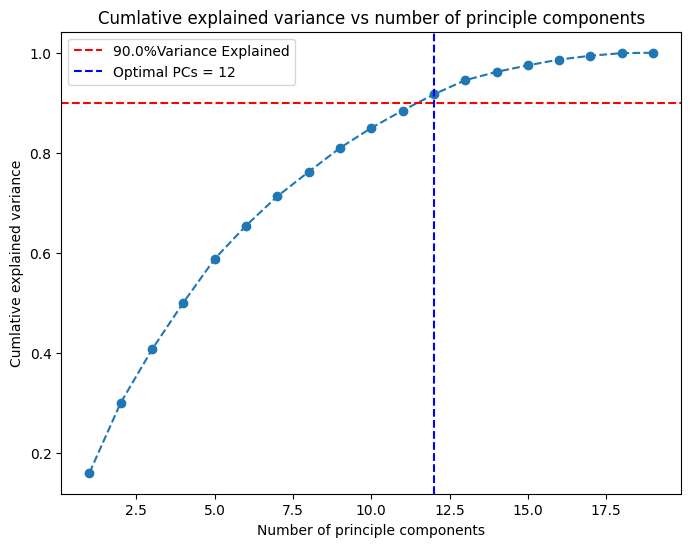

In [25]:
#Apply PCA without specifying the number of components
pca = PCA()
pca.fit(Nba_data_std)

#Compute explained variance
explained_variance = pca.explained_variance_ratio_
cumlative_variance = np.cumsum(explained_variance)
#explained_variance
cumlative_variance


#Find number of components that explains at least some threshold of variance
threshold = 0.9
n_components_thresh = np.argmax(cumlative_variance >= threshold) + 1
n_components_thresh

#Plot cumlative explained variance
plt.figure(figsize=(8,6))
plt.plot(range(1,len(cumlative_variance)+1), cumlative_variance, marker='o', linestyle="--")
plt.axhline(y=threshold, color='r', linestyle='--', label=f'{threshold*100}%Variance Explained')
plt.axvline(x=n_components_thresh, color='b', linestyle='--', label=f'Optimal PCs = {n_components_thresh}')
plt.xlabel("Number of principle components")
plt.ylabel("Cumlative explained variance")
plt.title("Cumlative explained variance vs number of principle components")
plt.legend()

Elbow Method

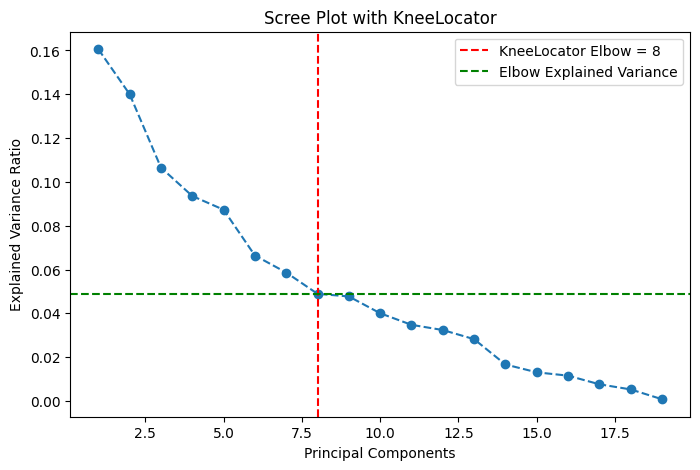

In [26]:
# Find the elbow point mathemetically
knee_locator = KneeLocator(range(1, len(explained_variance) + 1), explained_variance, curve='convex', direction='decreasing')
scree_components = knee_locator.knee

# scree plot with knee locator
plt.figure(figsize=(8,5))
plt.plot(range(1,len(explained_variance ) + 1), explained_variance, marker='o', linestyle='--')
plt.axvline(x=scree_components, color='r', linestyle='--', label=f'KneeLocator Elbow = {scree_components}')
plt.axhline(y=explained_variance[scree_components-1], color='g', linestyle='--', label=f'Elbow Explained Variance')
plt.xlabel("Principal Components")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot with KneeLocator")
plt.legend()
plt.show()

Compare cumulative explained variance for both methods

In [27]:
# compare cumulative explained variance for both methods
exp_varScree = np.sum(explained_variance[:scree_components])
exp_varThresh = np.sum(explained_variance[:n_components_thresh])

print(f"Percentage of variance explained by {scree_components} components: {exp_varScree:.2%}")
print(f"Percentage of variance explained by {n_components_thresh} components: {exp_varThresh:.2%}")

Percentage of variance explained by 8 components: 76.19%
Percentage of variance explained by 12 components: 91.68%


Converting PCA's to a Data Frame

In [28]:
# Conduct PCA using optimal number of components
pca = PCA(n_components=n_components_thresh)
Nba_Data_pca = pca.fit_transform(Nba_data_std)

# Convert PCA results to dataframe
NBA_Data_pca_df = pd.DataFrame(Nba_Data_pca, columns=[f'PC{i+1}' for i in range(Nba_Data_pca.shape[1])])
NBA_Data_pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
0,0.479185,-0.138514,-1.773943,-2.391391,-0.368098,0.682985,-0.292876,-0.909727,0.879924,-0.836316,-0.202952,-0.170268
1,-2.231233,-4.269411,-2.081671,0.630250,-0.381977,-0.368887,0.669167,-1.156312,0.704485,-0.434118,-1.841573,0.567590
2,-3.252022,-3.914721,-1.551052,0.790653,-1.599838,-0.885118,1.138924,-1.960924,1.273750,0.061212,-1.101009,-0.346891
3,0.552132,-1.846032,-1.779274,-0.687550,0.191869,-0.678929,0.835727,-1.693468,0.321202,0.360917,0.516525,0.236045
4,-1.885211,0.178365,-0.714605,-1.245601,-2.431353,-1.068203,0.496150,-0.328803,-1.352171,0.786398,-1.112003,-0.163856
...,...,...,...,...,...,...,...,...,...,...,...,...
15025,-2.432509,5.038324,-0.226463,3.359000,2.226125,0.923298,0.423732,2.117104,1.253045,-0.023634,0.706360,0.765096
15026,-3.021305,3.493849,-0.932739,3.729836,1.464164,1.515109,-0.514611,-0.397031,1.453791,-0.210482,0.339215,0.971795
15027,-3.962506,2.484871,-0.784119,2.331231,2.266138,-1.208324,-0.686815,0.780385,-1.493227,1.971783,0.589198,0.212808
15028,-4.003756,4.292378,-1.632004,1.534292,0.218066,-0.410270,-0.848141,1.336363,-1.116175,0.407570,0.627561,-0.219017


Display the loadings of each variable in each PC

In [29]:
var_names = nba_no_high_corr_nzv_df.columns
housing_loadings = pd.DataFrame(pca.components_.T, index=var_names, columns=[f'PC{i+1}' for i in range(pca.n_components_)])
housing_loadings.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
field_goals_made,0.352988,0.313461,-0.083697,0.203251,-0.026709,-0.064236,0.030143,-0.068827,0.052773,0.002717,-0.174016,-0.104849
field_goals_attempted,0.344936,0.170530,0.157921,0.269928,0.403398,-0.009995,-0.075167,0.094293,-0.079308,-0.089249,0.122229,0.133888
three_pointers_made,0.231525,0.237673,-0.143726,0.205601,-0.237135,-0.140734,-0.096494,-0.230998,-0.068295,0.361069,-0.298158,-0.045853
free_throws_made,-0.099159,-0.036589,0.218617,0.045850,-0.253341,0.659758,-0.039325,-0.014983,0.006343,0.069995,0.164149,-0.526190
rebounds_offensive,0.121412,-0.039614,0.348839,0.029136,0.503715,0.105860,-0.039359,-0.176150,-0.095494,0.473886,-0.007104,-0.088502


Compute absolute loadings

In [30]:
# Compute absolute loadings
abs_loadings = np.abs(pca.components_)

# compute median loading across all PCs
median_loadings =  np.median(abs_loadings)

# identify important variables (those loadings that exceed the median loading)
important_vars = np.any(abs_loadings > median_loadings, axis=0)

# extract var names
important_features = np.array(var_names)[important_vars]
#important_features

important_features

array(['field_goals_made', 'field_goals_attempted', 'three_pointers_made',
       'free_throws_made', 'rebounds_offensive', 'rebounds_defensive',
       'steals', 'blocks', 'turnovers', 'fouls_personal',
       'plus_minus_points', 'estimated_defensive_rating',
       'assist_to_turnover', 'estimated_pace', 'distance',
       'rebound_chances_offensive', 'secondary_assists',
       'free_throw_assists', 'defended_at_rim_field_goals_made'],
      dtype=object)

Data partioning, partition the data such that 80% is used for training and 20%

In [31]:
#dep_variable = Nba_data_std['points']
#ind_variable = Nba_data_std.loc[:, Nba_data_std.columns != 'points']

dep_variable = Nba_Data_pca[dep_var]
ind_variable = Nba_Data_pca.loc[:, Nba_data_std.columns != dep_var]

train_x, test_x, train_y, test_y = train_test_split(ind_variable, dep_variable, test_size=0.2, random_state=2142)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

modle fitting results

In [ ]:
#Add intercept term into the data before modeling
train_X = sm.add_constant(train_x)
#Model with training data
model = sm.OLS(train_y, train_X).fit()
#print model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              turnovers   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     3353.
Date:                Thu, 27 Mar 2025   Prob (F-statistic):               0.00
Time:                        16:15:40   Log-Likelihood:                -14504.
No. Observations:               22552   AIC:                         2.906e+04
Df Residuals:                   22526   BIC:                         2.927e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

In [ ]:
# Get predictions
ols_pred = model.predict(test_x)

# Calculate residuals
residuals = test_y - ols_pred

# Calculate regression statistics
ME = np.mean(residuals)
RMSE = np.sqrt(np.mean(residuals**2))
MAE = np.mean(np.abs(residuals))
MPE = np.mean((residuals / test_y) * 100)
MAPE = np.mean(np.abs(residuals / test_y) * 100)

# Print results
print(f"Mean Error (ME) : {ME:.4f}")
print(f"Root Mean Squared Error (RMSE) : {RMSE:.4f}")
print(f"Mean Absolute Error (MAE) : {MAE:.4f}")
print(f"Mean Percentage Error (MPE) : {MPE:.4f}")
print(f"Mean Absolute Percentage Error (MAPE) : {MAPE:.4f}")

ValueError: shapes (5638,25) and (26,) not aligned: 25 (dim 1) != 26 (dim 0)

### KNN Model

In [ ]:
from sklearn.neighbors import KNeighborsRegressor


knn_model = KNeighborsRegressor(n_neighbors=5, n_jobs=1).fit(train_x, train_y)
knn_model

KNeighborsRegressor(n_jobs=1)

In [ ]:
knn_pred = knn_model.predict(test_x)

import statsmodels.api as sm
import scipy.stats as stats

#compute residuals
knn_res = test_y - knn_pred


from dmba import regressionSummary

# ind test data (actual) vs knn predictions
regressionSummary(test_y, knn_pred)
regressionSummary(test_y, residuals)


Regression statistics

                      Mean Error (ME) : -0.0196
       Root Mean Squared Error (RMSE) : 0.6762
            Mean Absolute Error (MAE) : 0.5304
          Mean Percentage Error (MPE) : 56.1822
Mean Absolute Percentage Error (MAPE) : 103.2615


ValueError: operands could not be broadcast together with shapes (5638,) (22552,) 

## Comparing OLS MLR to KNN Model

The models will now be compared to determine which model to select for the presentation.